In [1]:
import os
os.chdir(path=os.getcwd().removesuffix('adialab-notebooks'))
import pandas as pd
import numpy as np
np.random.seed(42)
import json
from typing import Dict
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

# Modeling
import sklearn.ensemble
from sklearn.model_selection import  KFold
from sklearn.inspection import permutation_importance

# Visualization
import plotly.express as px
px.defaults.width = 1000
px.defaults.height = 600

In [2]:
# Get the data
X_train = pd.read_parquet('narrow-oskar/data/X_train.parquet')
X_train = X_train.drop(columns=['id']).copy()
y_train = pd.read_parquet('narrow-oskar/data/y_train.parquet')

In order to derive important features I decided to use [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) since it's one of the most robust approaches available (BorutaSHAP is much more computationally expensive).
* The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled. For each feature `j` (column of dataset D): For each repetition `k` in 1, ..., K: Randomly shuffle column j of dataset `D` to generate a corrupted version of the data named `D^k,j` and compute the score of model on corrupted data `D^k,j`.

* Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

* Using a validation set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the validation set might cause the model to overfit.

* Moreover, instead of using one train/test split, I will perform 10-fold cross validation.

* Additionally, I will consider a feature important on a given test set if its decrease in a model score exceeds that of a random variable.

In [3]:
# Create a custom scorer
'''
For a callable to be a scorer, it needs to meet the protocol specified by the following two rules:
1. It can be called with parameters (estimator, X, y), where estimator is the model that should be evaluated, X is validation data,
    and y is the ground truth target for X (in the supervised case) or None (in the unsupervised case).
2. It returns a floating point number that quantifies the estimator prediction quality on X, with reference to y. 
    Again, by convention higher numbers are better, so if your scorer returns loss, that value should be negated.
Source: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
'''

def get_rank_corr_score(
    estimator = None,
    X_test: pd.DataFrame = None,
    y_test: pd.DataFrame = None,
) -> float:
    
    y_pred = estimator.predict(X_test)
    score = spearmanr(y_pred, y_test)[0]
    score = np.round(score, 3)
    return score

Default sklearn's K-Fold CV could result in data leakage.

In order to avoid it, I should do:
* Purging - removing all observations from the train set whose labels overlap in time with those labels included in the test set.
* Embargoing - eliminating from the train set observations that immediately follow an observation in the test set.

Since features exhibit AR(1) trend-following process and provided that y column probably contains returns between two consecutive dates, I need to purge/ embargo `1 date`. For that reason as well as for the sake of simplicity, I will use these terms interchangeably.

In [4]:
def get_kfold_cv_permutation_importance(
    X_data: pd.DataFrame = None,
    y_data: pd.DataFrame = None,
    n_splits: int = 10,
) -> Dict:
    
    # Use dates to make the splits, instead of using rows directly
    dates = X_data['date'].unique() 
    kfcv = KFold(n_splits=n_splits)
    PURGE = 1
 
    # Store performance in a dict
    stats_CV = {}
    
    # Keep track of the number of folds
    i = 0
    for train, test in tqdm(kfcv.split(dates)):
        
        # Purge 1 date
        if test.min() > train.max():
            train = train[:-PURGE]
        elif test.max() < train.min():
            train = train[PURGE:]
        elif test.min() > train.min() and test.max() < train.max():
            train = np.concatenate((train[train < test.min()][:-PURGE], train[train > test.max()][PURGE:]))
        
        fold_train_X = X_data.loc[X_data['date'].isin(train), :].copy()
        fold_train_X = fold_train_X.drop(columns=['date']).copy()
        fold_train_y = y_data.loc[y_data['date'].isin(train), 'y'].copy()

        fold_test_X = X_data.loc[X_data['date'].isin(test), :].copy()
        fold_test_X = fold_test_X.drop(columns=['date']).copy()
        fold_test_y = y_data.loc[y_data['date'].isin(test), 'y'].copy()
        
        # Create a random feature
        fold_train_X.loc[:, 'random'] = np.random.normal(loc=0, scale=1, size=len(fold_train_X))
        fold_test_X.loc[:, 'random'] = np.random.normal(loc=0, scale=1, size=len(fold_test_X))
        
        # Random Forest with prepruning, i.e. custom values for
        # max_depth, min_samples_split, and min_samples_leaf
        model = sklearn.ensemble.RandomForestRegressor(
            random_state=42,
            max_depth=6,
            min_samples_split=100,
            min_samples_leaf=50,
            n_jobs=-1
        )
        model.fit(fold_train_X, fold_train_y)
        
        # Calculate permutation importance
        result = permutation_importance(
            estimator=model,
            X=fold_test_X,
            y=fold_test_y,
            random_state=42,
            n_repeats=6,
            n_jobs=-1,
            scoring=get_rank_corr_score,
    )
        # Store the results in a dict
        stats_CV[i] = result
        
        # Keep track of the number of folds
        i += 1
        
    return stats_CV

In [5]:
statsCV = get_kfold_cv_permutation_importance(X_data=X_train, y_data=y_train, n_splits=10)

0it [00:00, ?it/s]

In [6]:
import matplotlib.pylab as plt

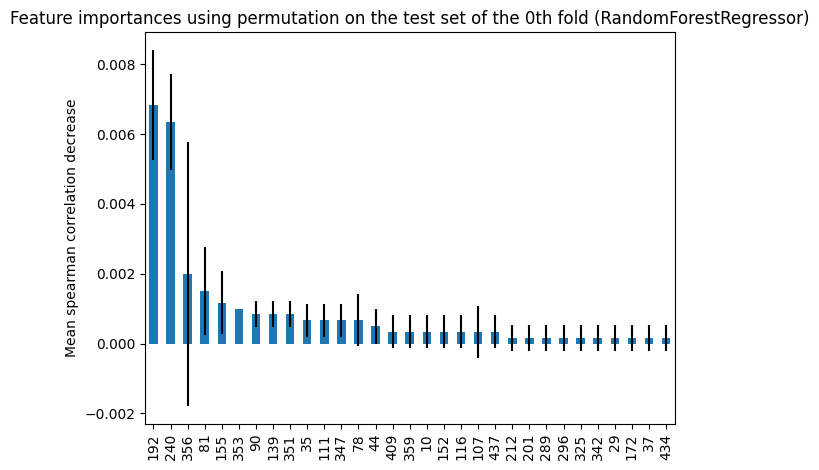

In [9]:
forest_importances = pd.Series(statsCV[0].importances_mean, index=X_train.drop(columns=['date']).columns.tolist() + ['random'])
forest_std = pd.Series(statsCV[0].importances_std, index=X_train.drop(columns=['date']).columns.tolist() + ['random'])
forest_importances = forest_importances.loc[forest_importances > forest_importances['random']].copy()
forest_std = forest_std.loc[forest_importances.index].copy()

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=forest_std, ax=ax)
ax.set_title('Feature importances using permutation on the test set of the 0th fold (RandomForestRegressor)')
ax.set_ylabel('Mean spearman correlation decrease')
fig.tight_layout()
plt.show()

In [10]:
stats = dict()
for key, value in statsCV.items():
    forest_importances = pd.Series(value.importances_mean, index=X_train.drop(columns=['date']).columns.tolist() + ['random'])
    forest_importances = forest_importances.loc[forest_importances > forest_importances['random']].copy()
    stats[key] = forest_importances.index

In [11]:
temp = list()
for key, value in stats.items():
    temp += list(value)

In [14]:
features = pd.Series(data=temp, name='names').value_counts()
features

240    10
192    10
356     9
155     8
159     7
       ..
1       1
120     1
455     1
449     1
460     1
Name: names, Length: 154, dtype: int64

In [17]:
# Looks like most of the features were 'significant' only once
features.loc[features > 1]

240    10
192    10
356     9
155     8
159     7
217     6
201     6
81      6
90      6
107     6
248     5
353     5
78      5
111     4
313     4
140     4
289     4
134     3
29      3
227     3
172     3
319     3
434     3
139     3
116     3
245     3
437     3
76      2
374     2
93      2
125     2
137     2
395     2
457     2
24      2
182     2
212     2
35      2
168     2
44      2
296     2
359     2
351     2
Name: names, dtype: int64

In [20]:
features.loc[features > 2]

240    10
192    10
356     9
155     8
159     7
217     6
201     6
81      6
90      6
107     6
248     5
353     5
78      5
111     4
313     4
140     4
289     4
134     3
29      3
227     3
172     3
319     3
434     3
139     3
116     3
245     3
437     3
Name: names, dtype: int64

Features which decrease in a model score exceeds that of a random variable `three or more times` are selected. Using more rigorous threshold would result in a pretty small number of features.

In [22]:
def store_list_as_json(data_list, folder_path, file_name):
    json_data = json.dumps(data_list)
    file_path = folder_path + '/' + file_name
    
    # 'w' - Write - Opens a file for writing, creates the file if it does not exist
    with open(file_path, 'w') as json_file:
        json_file.write(json_data)

In [26]:
# Saving the selected features in 'data' directory
folder_path = 'data'
file_name = 'features.json'
store_list_as_json(features.loc[features > 2].index.tolist(), folder_path, file_name)